In [1]:
!pip install facenet-pytorch
!pip install Pillow

In [1]:
from torch import nn
import torch

from torch import nn, optim
import torchvision.transforms as transforms

import numpy as np

In [2]:
try:
    from google.colab import drive
    IN_COLAB = True
    print("Running on Google Colab. ")
    drive.mount('/content/drive')
except:
    IN_COLAB = False
    print("Not running on Google Colab. ")

Not running on Google Colab. 


In [3]:
# utilizzo la libreria facenet_pytorch per caricare il modello InceptionResnetV1 preaddestrato sul dataset VGGFace2 e abilitare la classificazione.
from facenet_pytorch import InceptionResnetV1
import torch

resnet = InceptionResnetV1(pretrained='vggface2').eval()
resnet.classify = True

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
resnet = resnet.to(device)

Running on device: cuda:0


In [5]:
!pip install adversarial-robustness-toolbox[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 64.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 82.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.7/260.7 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3


In [28]:
from art.estimators.classification import PyTorchClassifier

from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import BasicIterativeMethod
from art.attacks.evasion import CarliniL2Method
from art.attacks.evasion import DeepFool
from art.attacks.evasion import ProjectedGradientDescent

In [29]:
# preparazione parametri per inizializzare il classificatore
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_shape = (3,160,160)
nb_classes = 8631
loss = nn.CrossEntropyLoss()    # Triplett loss = nn.TripletMarginLoss()
optimizer = optim.Adam(resnet.parameters())
classifier = PyTorchClassifier(model=resnet, loss=loss, input_shape=input_shape, nb_classes=nb_classes, optimizer=optimizer, clip_values=(0, 1))


In [30]:
from PIL import Image
from matplotlib import pyplot as plt
path = "face_dataset/test_set_MTCNN/n006460/0212_02.jpg"
img = Image.open(path).convert('RGB').resize((160, 160))
img = np.array(img)/ 255.0
img = img.astype(np.float32)
img = np.expand_dims(img, axis=0)
img = img.transpose(0, 3, 1, 2)
img.shape

(1, 3, 160, 160)

(160, 160, 3)


<Figure size 50x50 with 0 Axes>

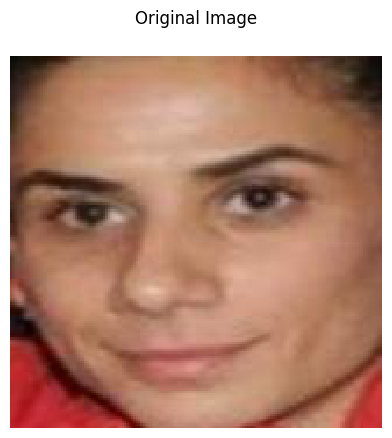

In [31]:
figsize = (0.5, 0.5)
plt.figure(figsize=figsize)
print(np.transpose(img.squeeze(0), (1,2,0)).shape)
plt.matshow(np.transpose(img.squeeze(0), (1,2,0)))
plt.axis('off')
plt.title('Original Image')
plt.show()

<Figure size 640x480 with 0 Axes>

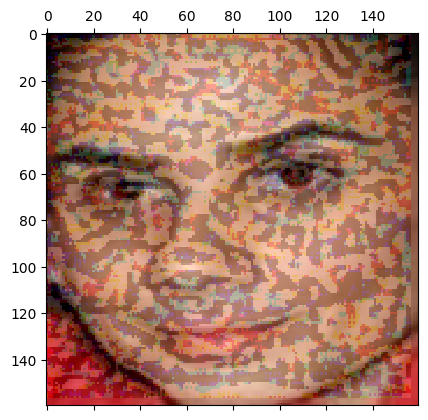

In [ ]:
epsilon = 0.1
targeted = False
fgsm_untargeted_attacker = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=targeted)

x_test_adv = fgsm_untargeted_attacker.generate(img)

x_test_adv = torch.tensor(x_test_adv)
plt.figure()
plt.matshow(np.transpose(x_test_adv.squeeze(0), (1,2,0)))
plt.show()

<Figure size 640x480 with 0 Axes>

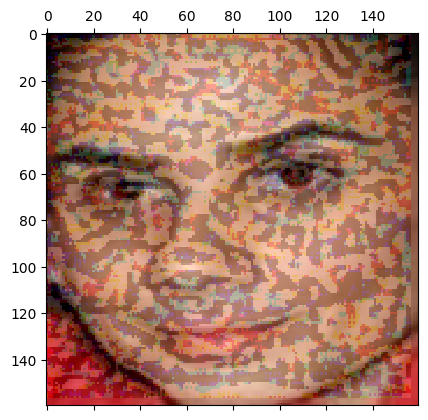

In [ ]:
epsilon = 0.1
epsilon_step = 0.1
max_iter = 5
targeted = False
bim_untargeted_attacker = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=epsilon_step, max_iter=max_iter, targeted=targeted, verbose=False)

x_test_adv = fgsm_untargeted_attacker.generate(img)

x_test_adv = torch.tensor(x_test_adv)
plt.figure()
plt.matshow(np.transpose(x_test_adv.squeeze(0), (1,2,0)))
plt.show()

C&W L_2:   0%|          | 0/1 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

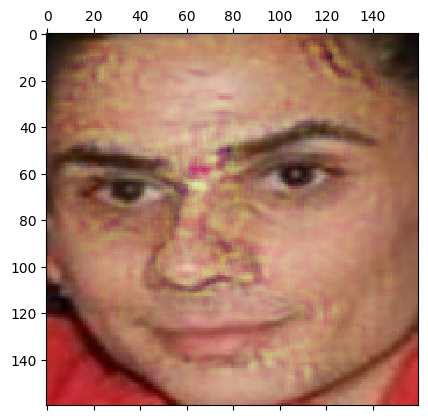

In [ ]:
binary_search_steps = 1
confidence = 0.5
max_iter = 5
learning_rate = 0.01
initial_const = 400

targeted = False




attack = CarliniL2Method(classifier=classifier, binary_search_steps=binary_search_steps,
                        confidence=confidence, max_iter=max_iter, learning_rate=learning_rate,
                        initial_const=initial_const, targeted=targeted)

x_test_adv = attack.generate(img)

x_test_adv = torch.tensor(x_test_adv)

plt.figure()
plt.matshow(np.transpose(x_test_adv.squeeze(0), (1,2,0)))
plt.show()


<Figure size 640x480 with 0 Axes>

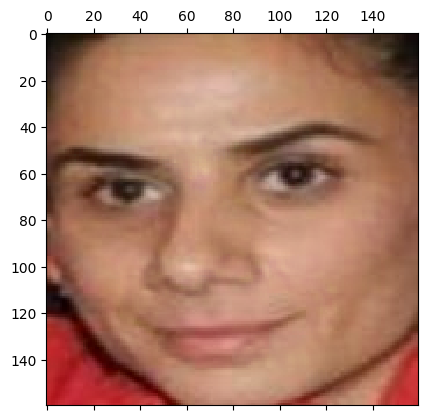

In [11]:
epsilon=0.9
max_iter = 2
attack = DeepFool(classifier=classifier, epsilon=epsilon, max_iter=max_iter, verbose=False)
test_image_adv_nn = attack.generate(img) #ritorna numpy array, per fare la valutazione ho bisogno di tensori
x_test_adv = torch.tensor(test_image_adv_nn)
plt.figure()
plt.matshow(np.transpose(x_test_adv.squeeze(0), (1,2,0)))
plt.axis('off')
plt.show()



In [12]:
def compute_perturbation(original_images, adversarial_samples):
    perturbations = []
    for original_image, adversarial_sample in zip(original_images, adversarial_samples):
        perturbation = np.mean(np.abs((np.array(original_image) - np.array(adversarial_sample))))
        perturbations.append(perturbation)
    return round(float(np.mean(perturbations)),4)

per=compute_perturbation(img, test_image_adv_nn)
print(per)

0.003


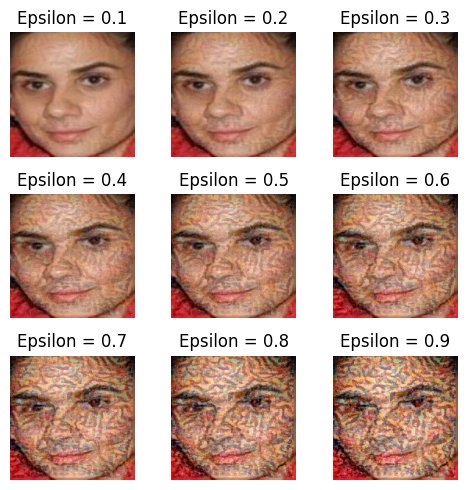

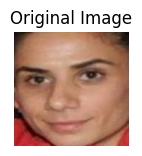

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from art.attacks.evasion import ProjectedGradientDescent

# Definizione delle variabili
targeted = False
epsilons = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
max_iter = 2

# Dimensioni del plot
total_fig_width = 5  # Larghezza totale del plot in pollici
total_fig_height = 5  # Altezza totale del plot in pollici
nrows = 3  # Numero di righe
ncols = 3  # Numero di colonne

# Creazione del plot con subplot 3x3
fig, axs = plt.subplots(nrows, ncols, figsize=(total_fig_width, total_fig_height))

# Iterazione sugli epsilon
for i, epsilon in enumerate(epsilons):
    eps_step = epsilon / 10.0
    #attack = ProjectedGradientDescent(classifier, eps=epsilon, eps_step=eps_step, max_iter=max_iter, targeted=targeted, verbose=False)
    attack = BasicIterativeMethod(estimator=classifier, eps=epsilon, eps_step=eps_step, max_iter=max_iter, targeted=targeted, verbose=False)
    #attack = FastGradientMethod(estimator=classifier, eps=epsilon, targeted=targeted)
    x_test_adv = attack.generate(img)
    x_test_adv = torch.tensor(x_test_adv)

    # Aggiunta dell'immagine al subplot corrispondente
    row = i // ncols
    col = i % ncols
    axs[row, col].imshow(np.transpose(x_test_adv.squeeze(0), (1, 2, 0)))
    axs[row, col].set_title(f"Epsilon = {epsilon}")  # Aggiunge il titolo con l'epsilon corrispondente

    # Rimuove gli assi
    axs[row, col].axis('off')

# Impostazione del layout e visualizzazione del plot
plt.tight_layout()
plt.show()

#save figure in
#path_save = "G:\\Drive condivisi\\AI4CYBSEC\\report\GenAdvExamples\PGD\\feasability.png"
#plt.savefig(path_save)

#plot also the original image 
total_fig_height = 5/3
total_fig_width = 5/3  # Altezza totale del plot in pollici
nrows = 1  # Numero di righe
ncols = 1  # Numero di colonne

# Creazione del plot con subplot 3x3
fig, axs = plt.subplots(nrows, ncols, figsize=(total_fig_width, total_fig_height))

#original image
axs.imshow(np.transpose(img.squeeze(0), (1, 2, 0)))
axs.set_title(f"Original Image")  # Aggiunge il titolo con l'epsilon corrispondente

# Rimuove gli assi
axs.axis('off')

# Impostazione del layout e visualizzazione del plot
plt.tight_layout()
plt.show()

#path_save = "G:\\Drive condivisi\\AI4CYBSEC\\report\GenAdvExamples\PGD\original.png"
#plt.savefig(path_save)


